<a href="https://colab.research.google.com/github/AbeRodz/Machine-learning/blob/analisis_inicial/Analisis_inicial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install geopandas pyshp contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/MyDrive/dataset/

/content/drive/MyDrive/dataset


In [4]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as colors
import shapefile as shp
import seaborn as sns
import numpy as np
import geopandas as gpd

In [5]:
geo_map = gpd.read_file("./shapefiles/taxi_zones.shp")

In [6]:
geo_map

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


## UTILITY FUNCTIONS

In [7]:
def open_sample_from_file(path : str,column_to_search: str = None , search_value:str = None, show_columns = False) -> pd.DataFrame:
    """
    Helper function to read a file sample with optional search conditions
    """
    parquet = path.endswith('parquet')
    func = getattr(pd, f'read_csv')
    if parquet:
        engine = 'auto'
        func = getattr(pd, f'read_parquet')
        return func(path, engine)
    
    if column_to_search:
        if search_value != None:
            df = func(path)
            return df[df[column_to_search] == search_value]
        
        return func(path)[column_to_search] 

    if show_columns:
        return func(path).columns

    return func(path)

In [8]:
def get_memory_usage(df):
  print(f"Memory used on DataFrame: {np.round(df.memory_usage(deep=True).sum()/(2**20),2)}MB")

In [9]:
def open_season(path: str = "./dataset/",season: str = "winter",open_all = False, drop_values = True, sample_divisor = 10) -> pd.DataFrame:
    """
    Helper function to open and separate the dataset on seasons.

    winter  01-01 -> - 02-28 (59 days of the year)
    spring  03-01 -> 05-31
    summer 06-01 -> 08-31
    autumn 09-01 -> 11-31
    """
    seasons = {"winter":[path + "yellow_tripdata_2022-01.parquet",path + "yellow_tripdata_2022-02.parquet"
                          ],
               "spring":[path +"yellow_tripdata_2022-03.parquet",path +"yellow_tripdata_2022-04.parquet",path + "yellow_tripdata_2022-05.parquet"
                          ],
               "summer":[path + "yellow_tripdata_2022-06.parquet",path +"yellow_tripdata_2022-07.parquet",path + "yellow_tripdata_2022-08.parquet"
                          ],
               "autumn" :[path + "yellow_tripdata_2022-09.parquet",path +"yellow_tripdata_2022-10.parquet",path + "yellow_tripdata_2022-11.parquet"
                          ]
               }
    
    if open_all:
      df = pd.DataFrame()
      for i in seasons:
        df  = pd.concat([pd.read_parquet(seasons.get(i)).drop(['VendorID','store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1), df], ignore_index=True)
        #map(pd.read_parquet, seasons.get(i)), df], ignore_index=True)
      if drop_values:
        #df = df.drop(['VendorID','store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1)
        df = df.sample(int(np.floor(len(df)/sample_divisor)), random_state = 42)
    else:
      if season in seasons:
        df  = pd.concat(
            map(pd.read_parquet, seasons.get(season)), ignore_index=True)
        if drop_values:
          df = df.drop(['VendorID','store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1)
      #df.sample(int(np.floor(len(df)/100)), random_state = 42)
    get_memory_usage(df)
    return df
    

In [10]:
df = open_season(path = "", open_all = True, sample_divisor = 10)

Memory used on DataFrame: 387.26MB


In [11]:
36256548/6


6042758.0

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625654 entries, 8972567 to 35930969
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           int64         
 6   DOLocationID           int64         
 7   payment_type           int64         
 8   fare_amount            float64       
 9   tip_amount             float64       
 10  tolls_amount           float64       
 11  total_amount           float64       
 12  airport_fee            float64       
dtypes: datetime64[ns](2), float64(8), int64(3)
memory usage: 387.3 MB


### Utilty plot functions (parallel plotting)

In [13]:
import io
from copy import deepcopy
from PIL import Image

def rasterize(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    pil_img = deepcopy(Image.open(buf))
    buf.close()
    
    return pil_img

In [14]:
def plot_distribution_with_info(df:pd.DataFrame = df,fig= None,col_name = None, show_info = False,ax = None, filter = None, title = 'plot'):
  """
  Makes a seaborn kdeplot from a dataFrame sample of the len(df/10), with mean and median displayed on the graph.
  """
  if (col_name is None) and (filter is None):
    return
  if col_name is not None:
    df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)[col_name]

  if filter is not None:
    df = filter.sample(int(np.floor(len(df)/10)),random_state = 42)
  if ax is None:
    fig, ax = plt.subplots()
  trans = ax.get_xaxis_transform()
  sns.kdeplot( df,ax= ax).set(title=title)
  if show_info:
    mean =df.mean()
    median = df.median()
    plt.axvline(x=mean,
                color='red')
    plt.text(mean, .99, 'mean', color='r', ha='right', va='top', rotation=90, transform=trans)

    plt.axvline(x=median,
                color='blue',
                ls='--', 
                lw=2.5)
    plt.text(median, .99, 'median', color='r', ha='right', va='top', rotation=90, transform=trans)

In [15]:
import matplotlib

def _parallel_plot_worker(data, plot_fn):
    fig = plt.figure(figsize=(5, 5))
    matplotlib.font_manager._get_font.cache_clear()  # necessary to reduce text corruption artifacts
    axes = plt.axes()
    
    plot_fn(df,fig,data,True, axes)
    pil_img = rasterize(fig)
    plt.close()
    
    return pil_img

In [16]:
from multiprocessing import Pool
import matplotlib.pyplot as plt
from functools import partial

def parallel_plot(plot_fn,col_name, grid_shape, figsize=None):
    """
    Helper function for parallel plotting, to speedup big dataset plots
    """
    
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    
    with Pool(processes=None) as pool:
        for ax, rastered in zip(axes.ravel(), pool.map(partial(_parallel_plot_worker, plot_fn=plot_fn), col_name)):
            ax.imshow(rastered, aspect='auto')
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
    
    plt.subplots_adjust(hspace=0, wspace=0)
    #fig.tight_layout()
    plt.show()

In [17]:
def drop_column(df, column_name):
  df.drop(column_name, axis =1, inplace = True)
  return df

In [18]:
def calculate_maxes(df: pd.DataFrame, col_name:str):
    total_amount_min = df[col_name].min()
    total_amount_max = df[col_name].max()
    return (total_amount_max,total_amount_min)

## Optimizacion de memoria 

Segun la documentacion de pandas
[Scaling to large datasets](https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html#load-less-data) hay varias formas de tratar datasets grandes, siendo una de las recomendaciones realizar type downcast que consiste en cambiar los types de las variables a types mas eficientes

En este caso se logra una reduccion de alrededor de 200mb en memoria

In [19]:
def clean_dataFrame(df):

  df = df[df['tpep_pickup_datetime'] != df['tpep_dropoff_datetime']]
  df = df[(df['total_amount'] > 0)]
  #df = df[df['passenger_count']>0]
  df = df.drop_duplicates().reset_index(drop=True)
  get_memory_usage(df)
  return df

In [20]:
df = clean_dataFrame(df)

Memory used on DataFrame: 357.12MB


In [21]:
df[["PULocationID","DOLocationID", "RatecodeID","payment_type"]] = df[["PULocationID","DOLocationID", "RatecodeID","payment_type"]].astype('category')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600678 entries, 0 to 3600677
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             category      
 5   PULocationID           category      
 6   DOLocationID           category      
 7   payment_type           category      
 8   fare_amount            float64       
 9   tip_amount             float64       
 10  tolls_amount           float64       
 11  total_amount           float64       
 12  airport_fee            float64       
dtypes: category(4), datetime64[ns](2), float64(7)
memory usage: 267.9 MB


In [23]:
df[["payment_type"]] = df[["payment_type"]].apply(pd.to_numeric, downcast="unsigned")
df[["passenger_count","trip_distance","fare_amount","tip_amount","tolls_amount","total_amount","airport_fee"]] = \
df[["passenger_count","trip_distance","fare_amount","tip_amount","tolls_amount","total_amount","airport_fee"]] .apply(pd.to_numeric, downcast="float")

In [24]:
get_memory_usage(df)

Memory used on DataFrame: 212.92MB


# TODO
revisar payment type en credit card

## 2. Análisis exploratorio inicial

utilizar el metodo de filtracion mutua y spearman

In [25]:
# from sklearn.feature_selection import mutual_info_regression, f_regression
# from sklearn.feature_selection import SelectKBest

# def select_features_mutual_info(X_train, y_train, X_test,k= 'all'):  
#   fs = SelectKBest(score_func=mutual_info_regression, k=k )  
#   fs.fit(X_train, y_train)  
#   X_train_fs = fs.transform(X_train)  
#   X_test_fs = fs.transform(X_test)
#   return X_train_fs, X_test_fs, fs
# def select_features_pearson(X_train, y_train, X_test,k= 'all'):  
#   fs = SelectKBest(score_func=f_regression, k=k )  
#   fs.fit(X_train, y_train)  
#   X_train_fs = fs.transform(X_train)  
#   X_test_fs = fs.transform(X_test)
#   return X_train_fs, X_test_fs, fs

# X_train_mi, X_test_mi, mi = select_features_mutual_info(X_train_red, y_train, X_test_red)
# X_train_pc, X_test_pc, pc = select_features_pearson(X_train_red, y_train, X_test_red)
# fig,axes = plt.subplots(2,1,figsize=(16,8))
# axes[0].set_title('Información mutua')
# sns.barplot( x = [c for c in df_train.columns[:-1] ], y = mi.scores_,ax=axes[0])
# axes[1].set_title('Pearson')
# sns.barplot( x = [c for c in df_train.columns[:-1] ], y = pc.scores_,ax=axes[1]); #Grafico el F score de cada feature
# pc.scores_

### Visualizar las primeras filas.

In [26]:
taxi_zones = open_sample_from_file("./taxi+_zone_lookup.csv")

In [27]:
taxi_zones

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [28]:
df.head(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
0,2022-11-20 14:50:04,2022-11-20 15:07:36,1.0,2.12,1.0,142,161,2,12.0,0.00,0.00,15.30,0.00
1,2022-06-01 17:08:02,2022-06-01 18:36:57,1.0,17.40,2.0,132,48,1,52.0,20.25,6.55,87.85,1.25
2,2022-05-16 21:58:00,2022-05-16 22:06:44,1.0,1.97,1.0,142,236,2,9.0,0.00,0.00,12.80,0.00
3,2022-10-13 08:52:09,2022-10-13 09:12:49,1.0,2.28,1.0,239,140,1,14.0,1.73,0.00,19.03,0.00
4,2022-01-27 12:51:16,2022-01-27 12:51:30,1.0,0.00,5.0,209,209,1,63.5,10.00,0.00,76.30,0.00


## Realizar un resumen de 5 números.

In [29]:
df.describe()

,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
count,3.477080e+06,3.600678e+06,3.600678e+06,3.600678e+06,3.600678e+06,3.600678e+06,3.600678e+06,3.477080e+06
mean,1.399482e+00,6.087514e+00,1.174710e+00,1.491346e+01,2.736044e+00,5.363036e-01,2.173068e+01,9.822646e-02
std,9.641292e-01,6.486304e+02,4.822931e-01,2.091895e+02,3.220133e+00,2.096804e+00,2.094410e+02,3.363550e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.300000e+00,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00
25%,1.000000e+00,1.110000e+00,1.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,1.230000e+01,0.000000e+00
50%,1.000000e+00,1.900000e+00,1.000000e+00,1.000000e+01,2.160000e+00,0.000000e+00,1.596000e+01,0.000000e+00
75%,1.000000e+00,3.570000e+00,1.000000e+00,1.650000e+01,3.360000e+00,0.000000e+00,2.288000e+01,0.000000e+00
max,9.000000e+00,3.896785e+05,4.000000e+00,3.958449e+05,3.880000e+02,9.118700e+02,3.958482e+05,1.250000e+00


### Identificar los tipos de datos: categórico, ordinal, etc. Responder para cada variable su tipo y si es informativa para un problema de clasificación (por ejemplo si se trata de un código, como una matrícula, o un nombre propio).

In [30]:
df.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float32
trip_distance                   float64
RatecodeID                     category
PULocationID                   category
DOLocationID                   category
payment_type                      uint8
fare_amount                     float64
tip_amount                      float32
tolls_amount                    float32
total_amount                    float64
airport_fee                     float32
dtype: object

In [31]:
df['passenger_count'].value_counts()

1.0    2571006
2.0     529642
3.0     138849
0.0      69789
5.0      63004
4.0      62275
6.0      42476
7.0         21
8.0         12
9.0          6
Name: passenger_count, dtype: int64

In [32]:
df['payment_type'].value_counts()

1    2752191
2     704909
0     123598
3      12176
4       7804
Name: payment_type, dtype: int64

In [33]:
df['RatecodeID'].value_counts()

1.0     3289318
2.0      133926
5.0       27461
99.0      12100
3.0        9574
4.0        4665
6.0          36
Name: RatecodeID, dtype: int64

| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|VendorID              | int64      | Categórica | Empresa telefonía
|tpep_pickup_datetime  | datetime64 |Fecha/hora | Inicio viaje
|tpep_dropoff_datetime | datetime64 | Fecha/hora | Fin viaje
|passenger_count       | float64    |Numerica | Cantidad pasajeros
|trip_distance         | float64    |Numerica  | Distancia viaje
|RatecodeID            | float64    | Categórica | Codigo tarifa
|store_and_fwd_flag    | object     | Categórica | Se guardo en memoria 
|PULocationID          | int64      |Categórica | Id zona comienzo
|DOLocationID          | int64      |Categórica | Id zona fin
|payment_type          | int64      | Categórica | Forma de pago
|fare_amount           | float64    |Numerica | Monto del viaje
|extra                 | float64    |Numerica | Extras
|mta_tax               | float64    |Numerica | Impuesto MTA
|tip_amount            | float64    |Numerica | Propina
|tolls_amount          | float64    |Numerica | Monto peajes
|improvement_surcharge | float64    |Numerica | Recargo por mejoras
|total_amount          | float64    | Numerica| Monto total
|congestion_surcharge  | float64    | Numerica | Recargo por congestión
|airport_fee           | float64    |Numerica | Tarifa aeropuerto           |

### Identificar las variables de entrada y de salida del problema. 

### Variables de Entrada

| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|tpep_pickup_datetime  | datetime64 |Fecha/hora | Inicio viaje
|tpep_dropoff_datetime | datetime64 | Fecha/hora | Fin viaje
|passenger_count       | float64    |Numerica | Cantidad pasajeros
|trip_distance         | float64    |Numerica  | Distancia viaje
|PULocationID          | int64      |Categórica | Id zona comienzo
|DOLocationID          | int64      |Categórica | Id zona fin
|payment_type          | int64      | Categórica | Forma de pago
|fare_amount           | float64    |Numerica | Monto del viaje calculado por el taximetro
|tip_amount            | float64    |Numerica | Propina
|tolls_amount          | float64    |Numerica | Monto peajes
|airport_fee           | float64    |Numerica | Tarifa aeropuerto           |



### Analisis por tipo de variable

In [34]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=8, ylabelsize=8,figsize=(18,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

In [35]:
numerical_columns = ["passenger_count","trip_distance","fare_amount", "tip_amount","tolls_amount", "total_amount", "airport_fee"]
categorical_columns = ["RatecodeID","PULocationID","DOLocationID", "payment_type"]

## plots categoricos

<Axes: xlabel='RatecodeID', ylabel='count'>

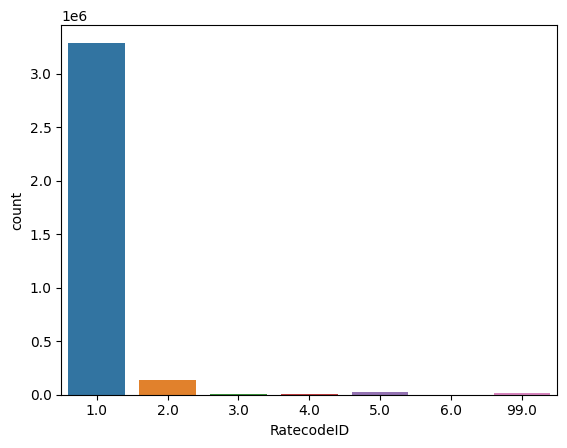

In [36]:
sns.countplot(df, x="RatecodeID")

<Axes: xlabel='payment_type', ylabel='count'>

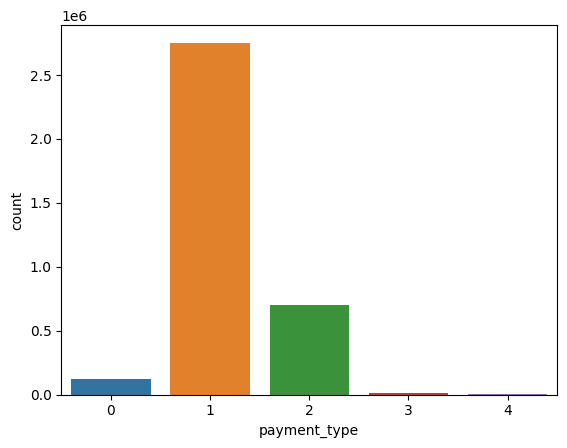

In [37]:
sns.countplot(df, x="payment_type")

<Axes: xlabel='PULocationID', ylabel='count'>

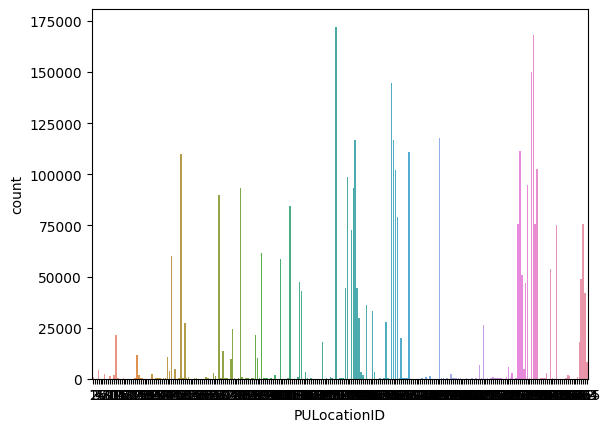

In [38]:
sns.countplot(df, x="PULocationID")

<Axes: xlabel='DOLocationID', ylabel='count'>

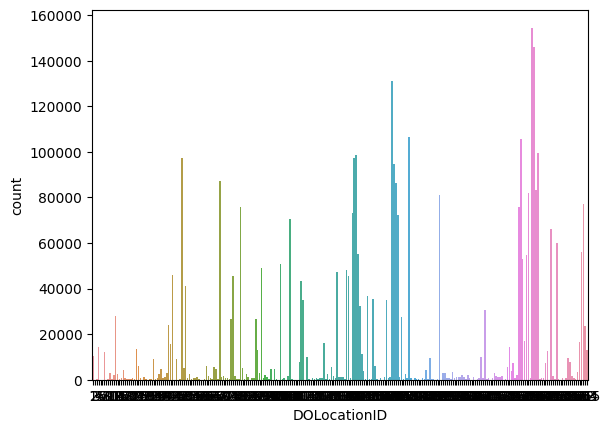

In [39]:
sns.countplot(df, x="DOLocationID")

### Plots Numericos (distribucion de los datos)

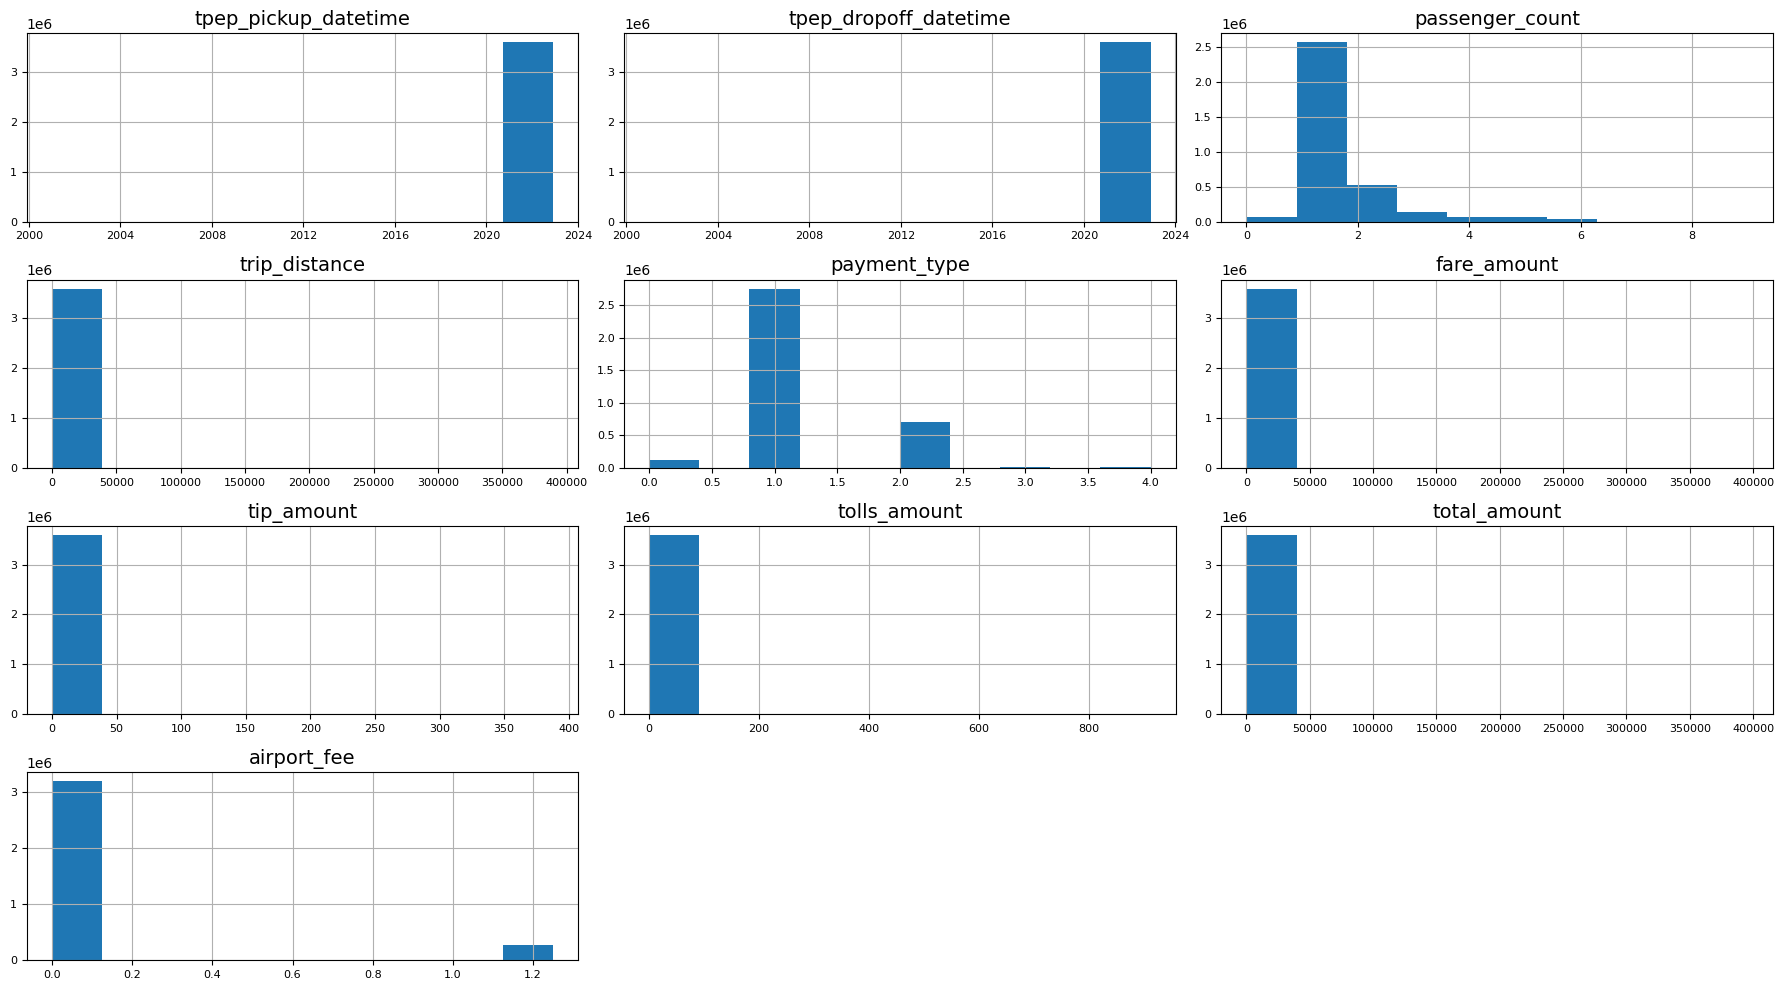

In [40]:
display_dataset_distributions(df)

In [41]:
df.total_amount.median()

15.96

In [42]:
df.total_amount.mode()

0    10.8
Name: total_amount, dtype: float64

In [43]:
df.total_amount.mean()

21.730683471279573

### Veamos total_amount cerca de la media

In [44]:
df.total_amount.value_counts()

10.80     53244
11.30     53068
11.80     52787
10.30     51327
12.36     50741
          ...  
90.34         1
193.56        1
166.42        1
308.50        1
301.93        1
Name: total_amount, Length: 12855, dtype: int64

# Graficando columnas numericas con mas detalle

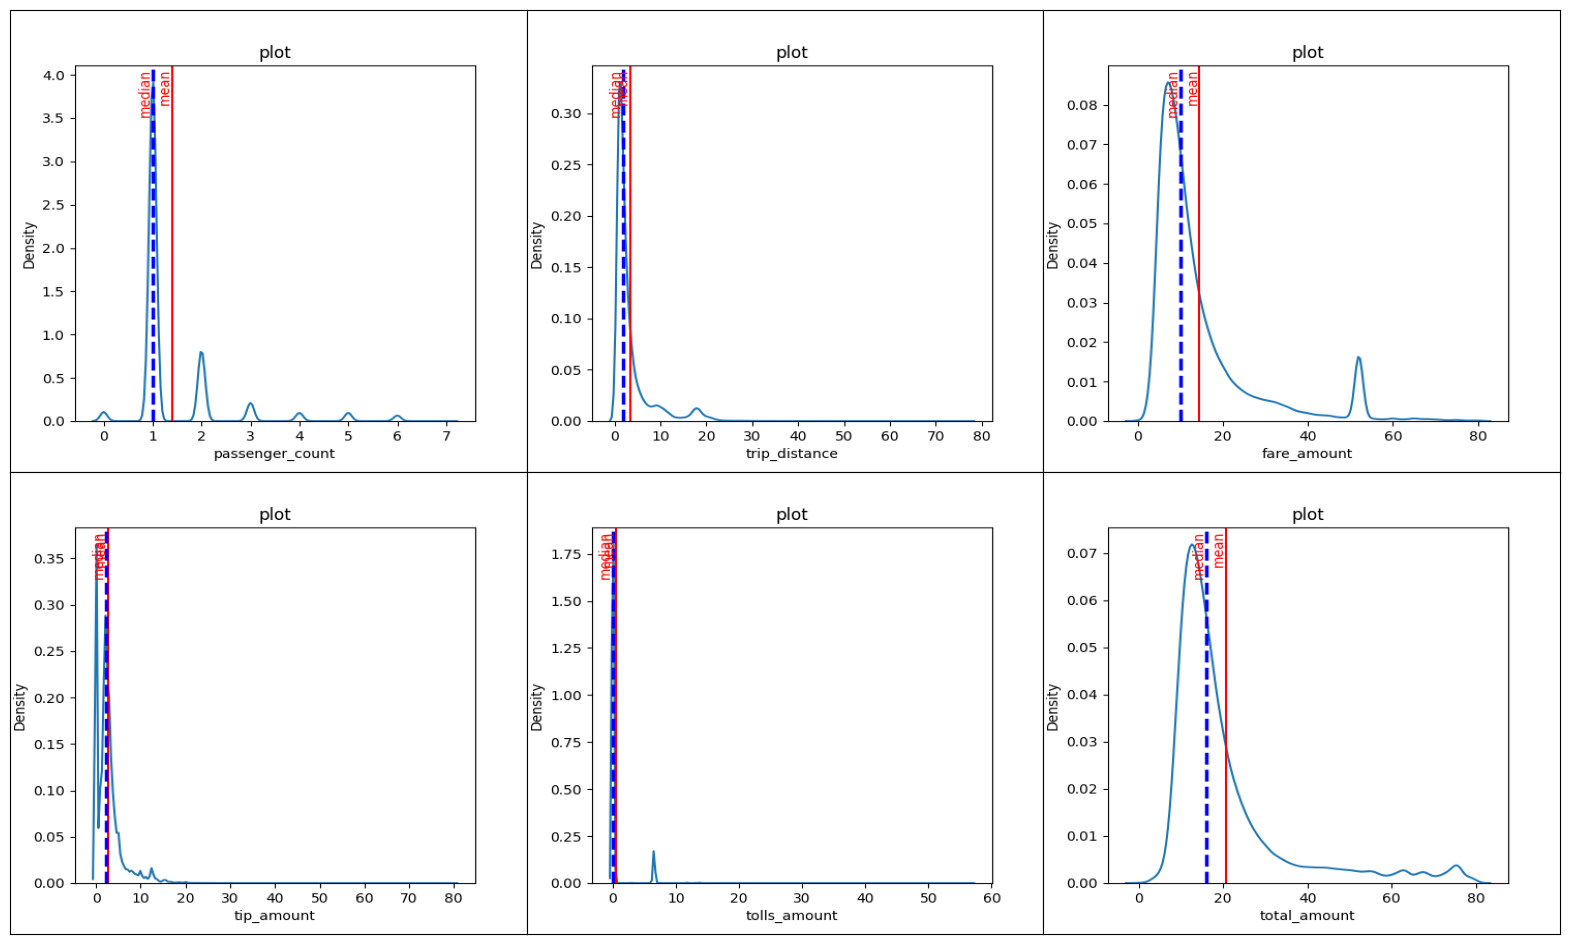

In [45]:
parallel_plot(plot_fn=plot_distribution_with_info,col_name= numerical_columns, grid_shape=(2, 3), figsize=(20, 12))

### De las variables tpep_pickup_datetime tpep_dropoff_datetime  se puede obtener mas data, al distribuirla por hora, fecha, duracion de la trayectoria

In [46]:
# utilzar esta funcion con cuidado, ya que devuelve el dataframe con la columna eliminada
#df = drop_column(df, "weekday")

In [47]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['date'] = df['tpep_pickup_datetime'].dt.normalize()
df['time_of_day'] = df['tpep_pickup_datetime'].dt.hour
#df['weekday'] = df['date'].dt.day_name() <- irrelevante?
df['duration_m'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration_m'] = df['duration_m'] / np.timedelta64(1, 'm')
df['day_of_year'] =pd.to_datetime(df['tpep_dropoff_datetime']).dt.strftime('%m-%d')
cal = calendar()
holidays = cal.holidays(start='2022-01-01', end='2022-12-31')
df['holiday'] = df['date'].isin(holidays)
df['day_week'] = df['date'].dt.dayofweek
df.loc[df['day_week'] >= 5, 'day_type'] = "weekend"
df.loc[df['day_week'] < 5, 'day_type'] = "workday"
df.loc[df['holiday'] == True, 'day_type'] = "holiday"
df = df.drop(['holiday'], axis=1)

In [48]:
df[["duration_m"]] = df[["duration_m"]] .apply(pd.to_numeric, downcast="float")
df[["day_week", "time_of_day"]] = df[["day_week", "time_of_day"]] .apply(pd.to_numeric, downcast="unsigned")
df[["day_type"]] = df[["day_type"]].astype('category')

In [49]:
df['date']

0         2022-11-20
1         2022-06-01
2         2022-05-16
3         2022-10-13
4         2022-01-27
             ...    
3600673   2022-10-12
3600674   2022-04-28
3600675   2022-11-08
3600676   2022-01-08
3600677   2022-02-26
Name: date, Length: 3600678, dtype: datetime64[ns]

## Plots de variables de fecha

<Axes: xlabel='day_week', ylabel='Count'>

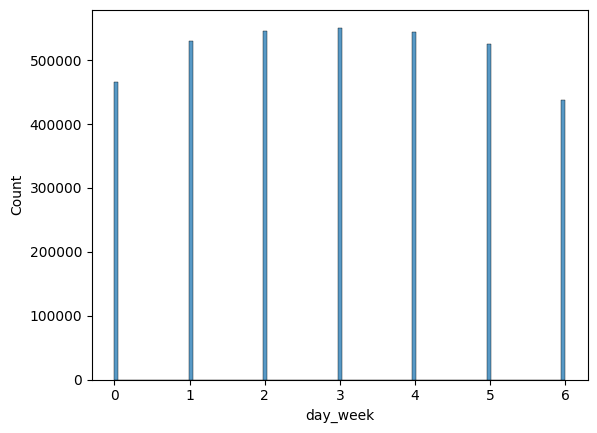

In [50]:
sns.histplot(df["day_week"])

In [51]:
date_columns = ["duration_m","time_of_day","day_week"]

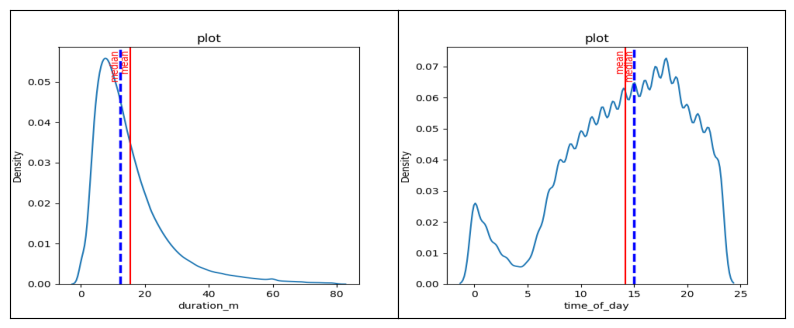

In [52]:
parallel_plot(plot_fn=plot_distribution_with_info,col_name= date_columns[:-1], grid_shape=(1, 2), figsize=(10, 4))

In [53]:
df[(df["time_of_day"] == 5)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee,date,time_of_day,duration_m,day_of_year,day_week,day_type
198,2022-06-12 05:18:38,2022-06-12 05:49:18,1.0,8.10,99.0,17,68,1,29.2,0.00,0.00,30.00,0.00,2022-06-12,5,30.666667,06-12,6,weekend
256,2022-09-28 05:59:26,2022-09-28 06:04:56,1.0,1.12,1.0,186,230,1,6.0,0.49,0.00,10.29,0.00,2022-09-28,5,5.500000,09-28,2,workday
308,2022-03-17 05:05:29,2022-03-17 05:28:37,1.0,10.35,1.0,230,138,2,31.0,0.00,6.55,41.35,0.00,2022-03-17,5,23.133333,03-17,3,workday
410,2022-09-02 05:50:30,2022-09-02 05:55:45,0.0,1.20,1.0,249,186,1,6.5,2.05,0.00,12.35,0.00,2022-09-02,5,5.250000,09-02,4,workday
779,2022-05-18 05:51:51,2022-05-18 06:13:49,1.0,16.57,2.0,107,132,1,52.0,15.46,6.55,77.31,0.00,2022-05-18,5,21.966667,05-18,2,workday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599773,2022-03-12 05:05:21,2022-03-12 05:16:12,1.0,2.26,1.0,48,239,2,10.0,0.00,0.00,13.80,0.00,2022-03-12,5,10.850000,03-12,5,weekend
3599947,2022-03-14 05:34:20,2022-03-14 05:37:56,1.0,0.90,1.0,100,161,1,5.0,1.76,0.00,10.56,0.00,2022-03-14,5,3.600000,03-14,0,workday
3600025,2022-03-03 05:36:21,2022-03-03 05:39:46,6.0,1.06,1.0,234,113,1,5.5,1.86,0.00,11.16,0.00,2022-03-03,5,3.416667,03-03,3,workday
3600358,2022-06-18 05:27:55,2022-06-18 05:52:27,1.0,14.60,1.0,100,259,2,41.0,0.00,0.00,44.80,0.00,2022-06-18,5,24.533333,06-18,5,weekend


<Axes: xlabel='time_of_day', ylabel='Count'>

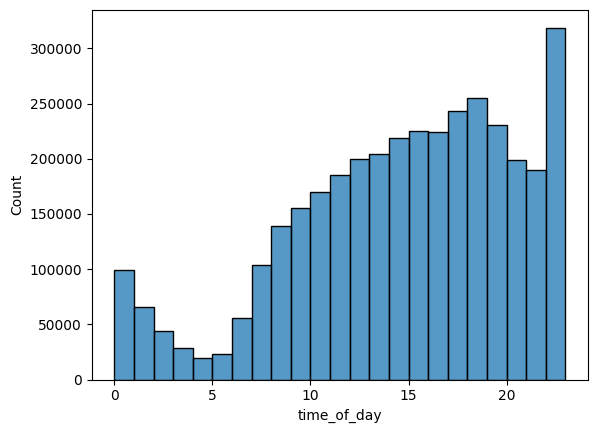

In [54]:
sns.histplot(df["time_of_day"], bins = 100,binwidth= 1, stat = 'count')

In [55]:
df['day_type'].value_counts()

workday    2562308
weekend     962653
holiday      75717
Name: day_type, dtype: int64

In [56]:
holidays = df[df['day_type']=='holiday'].reset_index(drop = True)
weekends = df[df['day_type']=='weekend'].reset_index(drop = True)
workdays =     df[df['day_type']=='workday'].reset_index(drop = True)

In [57]:
trip_filter_holiday = holidays[(holidays["trip_distance"]<=50)]["trip_distance"]
trip_filter_weekends = weekends[(weekends["trip_distance"]<=50)]["trip_distance"]
trip_filter_workday = workdays[(workdays["trip_distance"]<=50)]["trip_distance"]

In [58]:
day_type_plots = [{"holidays":holidays,"filter":trip_filter_holiday},{"weekends":weekends,"filter":trip_filter_weekends},{"workdays":workdays,"filter":trip_filter_workday}]

In [59]:
def plot_multiple_distributions(df_plots: list[dict],fig = None, figsize: tuple = (10,5), col_name: str = None, ax = None):
  cols = len(df_plots)
  fig, axes = plt.subplots(1,cols, figsize=figsize)
  axes = axes.ravel()

  for ax in range(cols):
    keys = list(df_plots[ax].keys())
    filter = None
    if col_name is None:
      filter = df_plots[ax].get(keys[1])
    plot_distribution_with_info(df_plots[ax].get(keys[0]),col_name = col_name, filter = filter,   ax = axes[ax], title = keys[0] )

  plt.show()

## Ploteando distribuciones por tipo de dia

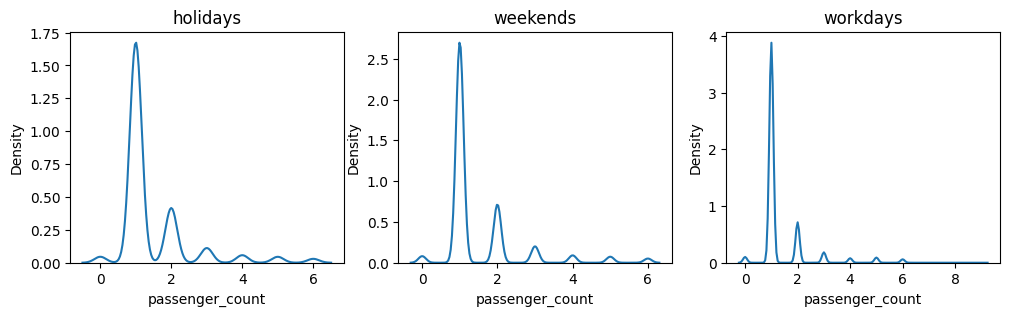

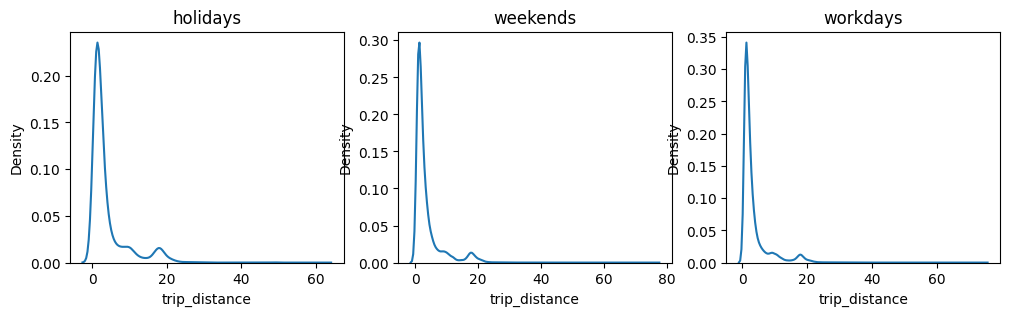

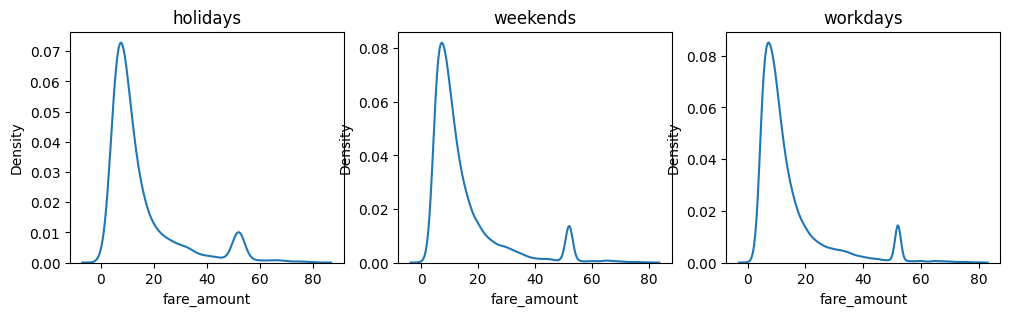

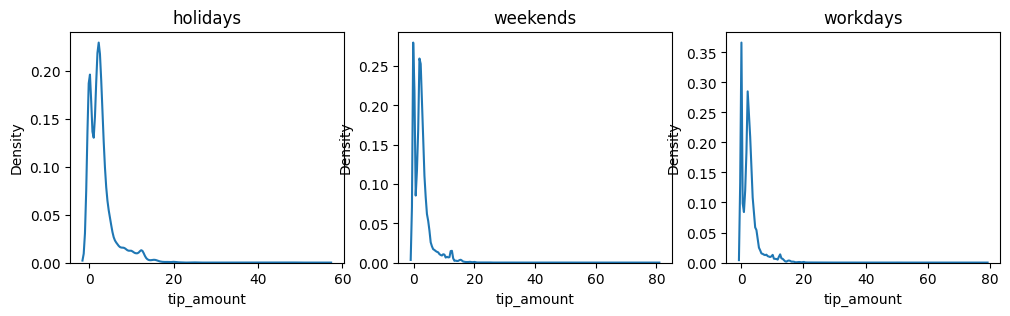

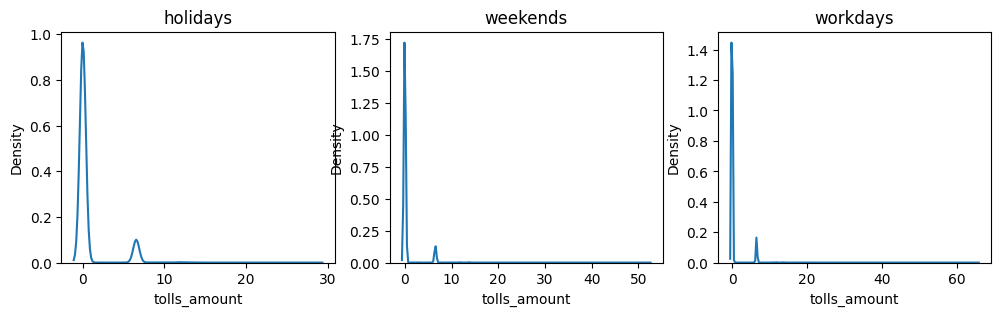

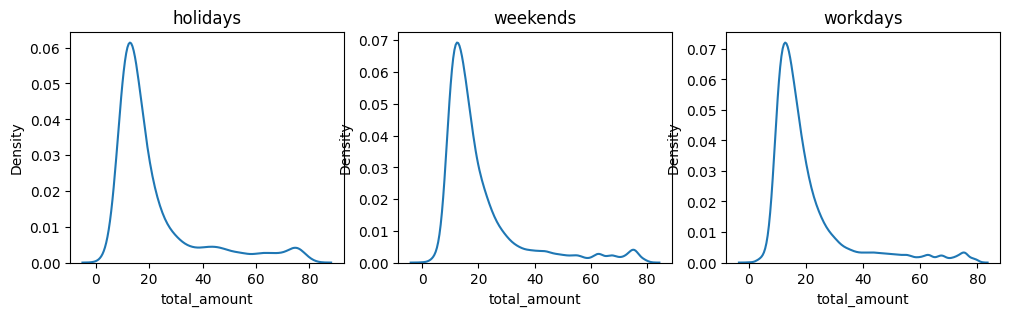

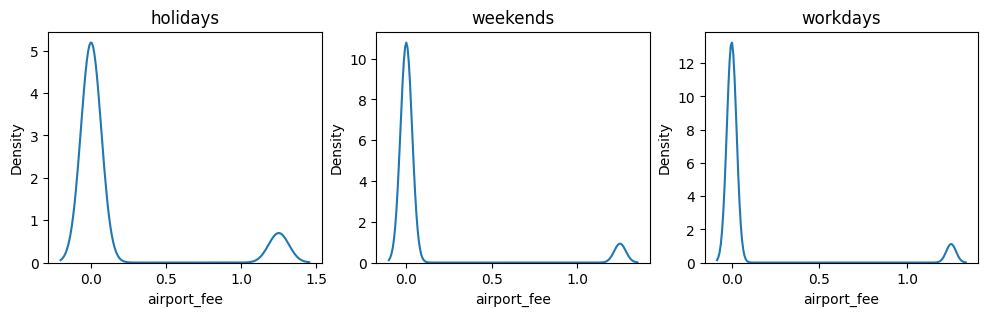

<Figure size 640x480 with 0 Axes>

In [60]:
for c in numerical_columns:
  plot_multiple_distributions(day_type_plots, figsize = (12,3), col_name = c)
plt.tight_layout()

## Utilizando data geografica

In [61]:
pu_zone = df.groupby(['PULocationID'], as_index=False).size()
do_zone = df.groupby(['DOLocationID'], as_index=False).size()
pu_zone = gpd.GeoDataFrame(pd.merge(pu_zone, geo_map, left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
do_zone = gpd.GeoDataFrame(pd.merge(do_zone, geo_map, left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)

In [62]:
df.groupby(['PULocationID'], as_index=False).size()

,PULocationID,size
0,1,926
1,2,4
2,3,42
3,4,4412
4,5,62
...,...,...
254,261,17852
255,262,48690
256,263,75916
257,264,42106


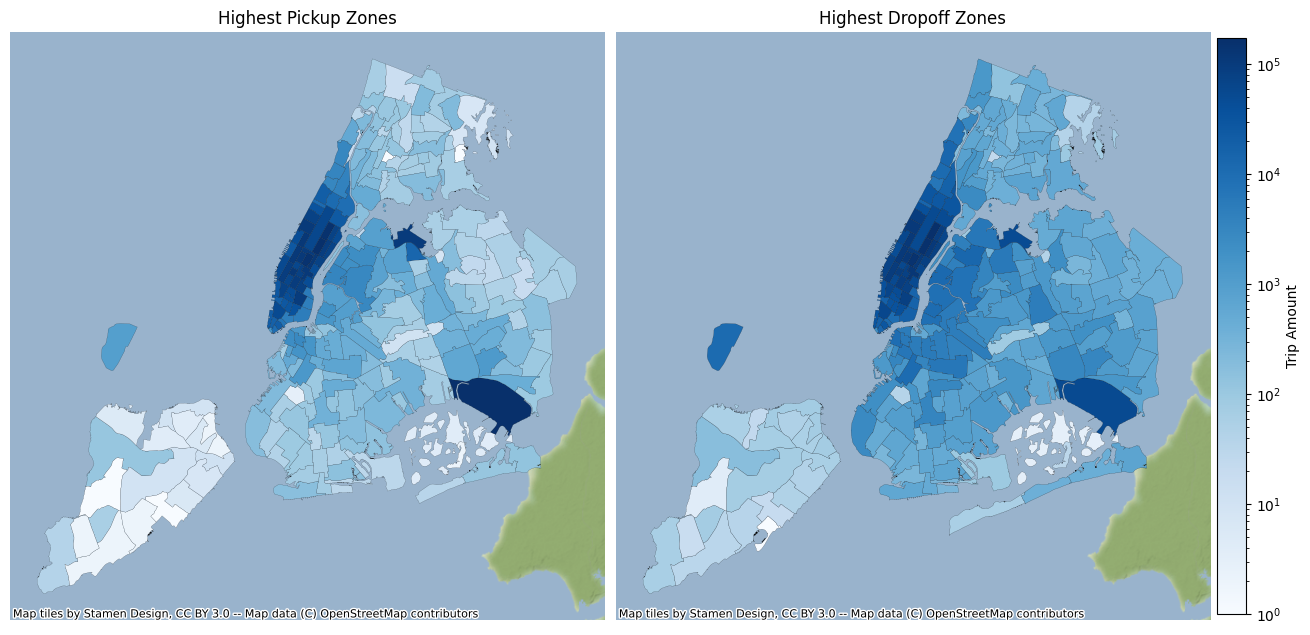

In [63]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8, wspace=0.02, hspace=0.02)
# create a normalized colorbar
vmin, vmax = pu_zone['size'].min(), pu_zone['size'].max()
axs[0] = pu_zone.plot(column='size', linewidth=0.09, edgecolor='k', figsize=(10, 10), 
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, ax=axs[0]) 
ctx.add_basemap(axs[0])
vmin, vmax = do_zone['size'].min(), do_zone['size'].max()
axs[1] = do_zone.plot(column='size', linewidth=0.1, edgecolor='k', figsize=(10, 10), 
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, ax=axs[1])
ctx.add_basemap(axs[1])
axs[0].set_title('Highest Pickup Zones')
axs[1].set_title('Highest Dropoff Zones')
axs[0].set_axis_off()
axs[1].set_axis_off()
# draw the color bar
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Trip Amount')
plt.show()

In [64]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'airport_fee', 'date', 'time_of_day', 'duration_m',
       'day_of_year', 'day_week', 'day_type'],
      dtype='object')

In [65]:
#df = df[df['date'].dt.year==2022]
#df = df[df['date'].dt.dayofyear <= 58]

In [66]:
df['date'].dt.dayofyear.max()

365

In [67]:
df['trips_number_by_day_type'] = 1
day_type_agg = df.groupby('day_type')['PULocationID'].agg('count')

In [68]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'airport_fee', 'date', 'time_of_day', 'duration_m',
       'day_of_year', 'day_week', 'day_type', 'trips_number_by_day_type'],
      dtype='object')

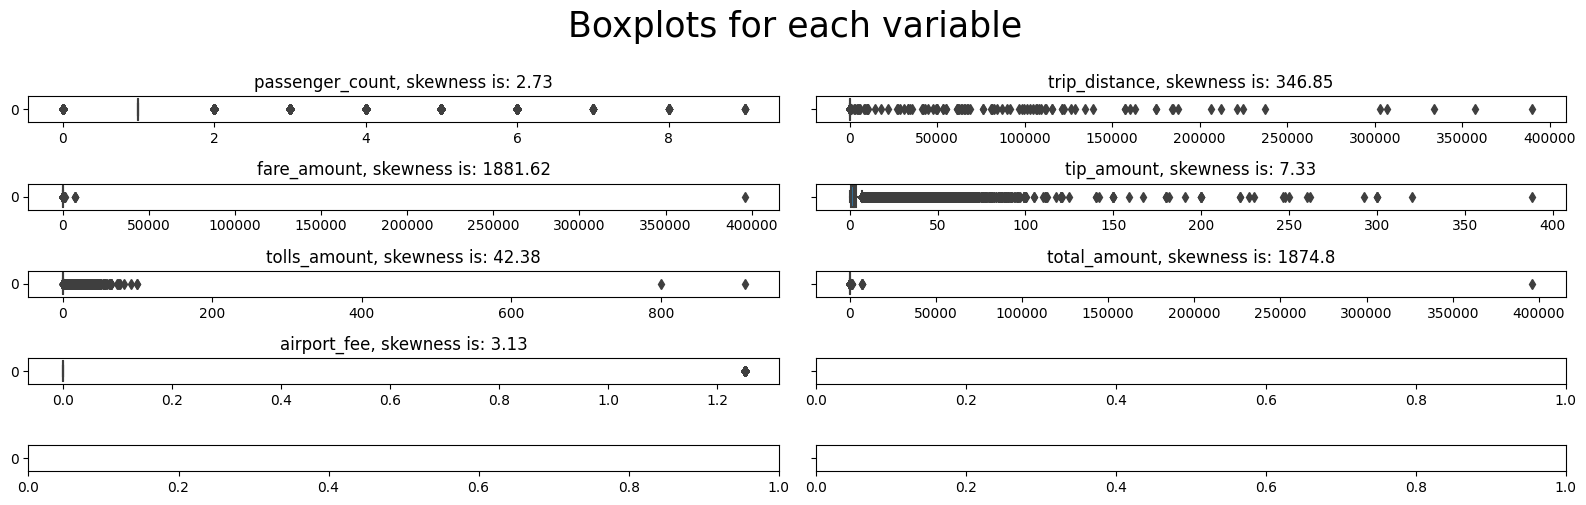

In [69]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numerical_columns, rows=5, cols=2, suptitle='Boxplots for each variable')
plt.tight_layout()

In [70]:
def plot_distribution_with_info(df:pd.DataFrame = df,fig= None,col_name = None, show_info = False,ax = None, filter = None, title = 'plot'):
  """
  Makes a seaborn kdeplot from a dataFrame sample of the len(df/10), with mean and median displayed on the graph.
  """
  if (col_name is None) and (filter is None):
    return
  if col_name is not None:
    df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)[col_name]

  if filter is not None:
    df = filter.sample(int(np.floor(len(df)/10)),random_state = 42)
  if ax is None:
    fig, ax = plt.subplots()
  trans = ax.get_xaxis_transform()
  sns.kdeplot( df,ax= ax).set(title=title)
  if show_info:
    mean =df.mean()
    median = df.median()
    plt.axvline(x=mean,
                color='red')
    plt.text(mean, .99, 'mean', color='r', ha='right', va='top', rotation=90, transform=trans)

    plt.axvline(x=median,
                color='blue',
                ls='--', 
                lw=2.5)
    plt.text(median, .99, 'median', color='r', ha='right', va='top', rotation=90, transform=trans)

<Axes: xlabel='duration_m', ylabel='Density'>

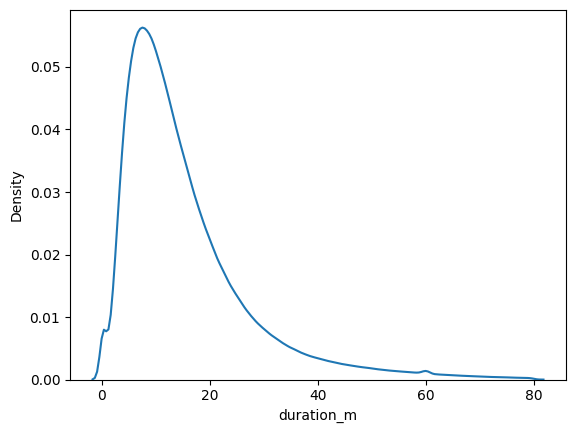

In [71]:
  sns.kdeplot(df[(df['duration_m']<=80) & (df['duration_m']>=0)]['duration_m'])

In [72]:
df['log_duration'] = df['duration_m'].apply(lambda x : np.log(x))

In [81]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer,MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline 

Text(0.5, 1.0, 'Modelo lineal de referencia')

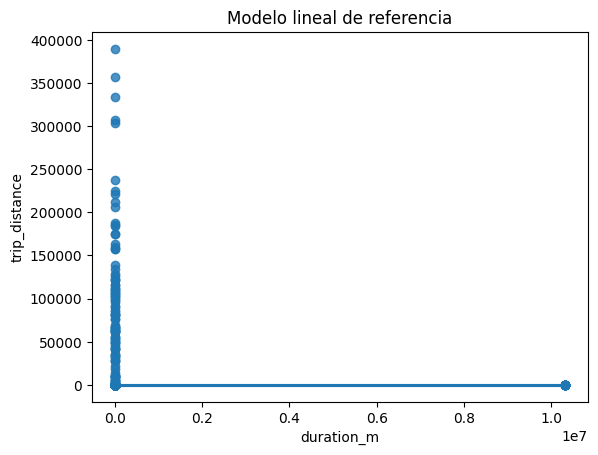

In [107]:
#fig,axes = plt.subplots(1,1,figsize=(20,4))
#axes = axes.ravel()
sns.regplot(x="duration_m", y="trip_distance", data=df, order=1).set_title("Modelo lineal de referencia")
# sns.regplot(x="LSTAT", y="MEDV", data=df, order=1,ax=axes[1]).set_title("Aproximadamente lineal")
# sns.regplot(x="RM", y="MEDV", data=df, order=1,ax=axes[2]).set_title("Algo de linealidad")
# sns.regplot(x="CRIM", y="MEDV", data=df, order=1,ax=axes[3]).set_title("Escasa linealidad");

In [74]:
      
# Distribución transformada    
pipeline = Pipeline(
    steps=[
        ( 'qt' , QuantileTransformer(output_distribution= 'normal'))
])
X_transformed = pipeline.fit_transform(s)
sns.histplot(X_transformed, bins=20, color='r', kde=True)


NameError: ignored

In [98]:
def transform_variable(df, col_name, method = "yeo-johnson"):
    power = PowerTransformer(method= method, standardize= True )
    if method == "box-cox":
      scaler = MinMaxScaler(feature_range=(1, 2))
      steps = [('s', scaler),('p', power)]
    else:
      steps = [('p', power)]
    df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)

    pipeline = Pipeline(
        steps=steps
    )
    X_transformed = pipeline.fit_transform(df[col_name].to_numpy().reshape(-1, 1))
    sns.histplot(X_transformed, color='r', kde=True).set_title("{} con {}($\lambda={:2f}$)".format(
                  col_name,method, pipeline.named_steps['p'].lambdas_[0]) )


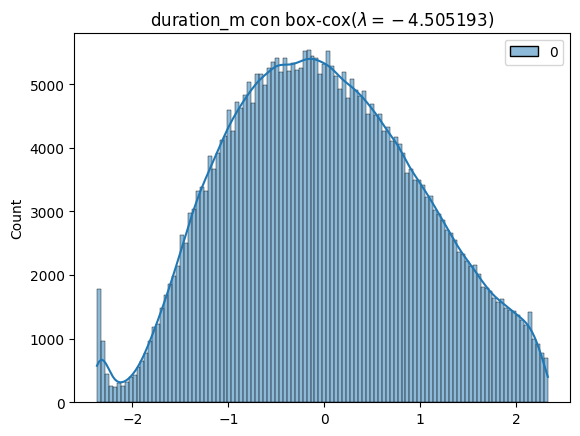

In [99]:
transform_variable(df, "duration_m", "box-cox")

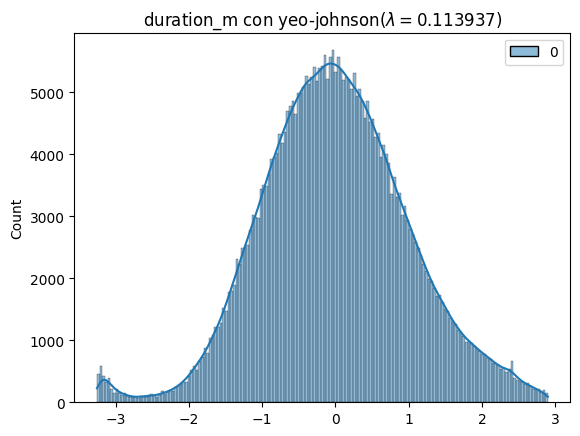

In [100]:
transform_variable(df, "duration_m")

In [101]:
def outlier_diagnostic_plots(df, col_name):
    import scipy.stats as stats
    fig, axes = plt.subplots(1,3,figsize=(20,4))
    df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)
    sns.histplot(df[col_name], bins=30, ax=axes[0], kde=True)
    axes[0].set_title('Histograma')
    
    stats.probplot(df[col_name], dist="norm", plot=axes[1])
    axes[1].set_title('QQ')
    
    # boxplot    
    sns.boxplot(y=df[col_name],ax=axes[2])
    axes[2].set_title('Box&Whiskers')

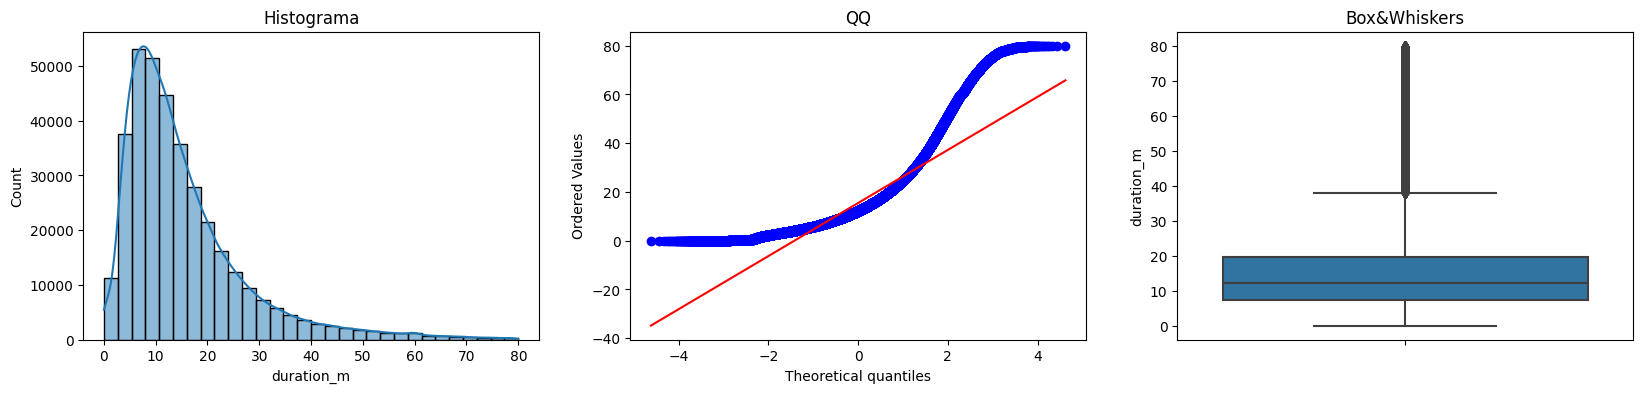

In [102]:
outlier_diagnostic_plots(df, "duration_m")

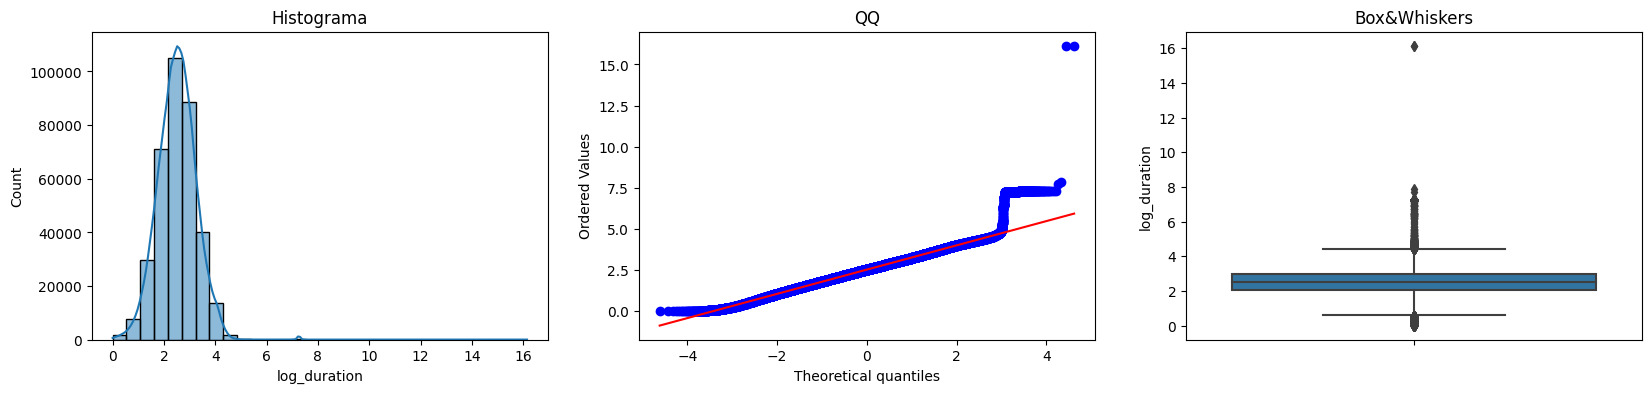

In [96]:
outlier_diagnostic_plots(df, "log_duration")

In [ ]:


outliers_columns = ['duration', 'liveness', 'loudness', 'speechiness']

for col in numerical_columns:
  outlier_diagnostic_plots(df, col)

In [ ]:
tip_by_day = df.groupby(df['passenger_count'])['day_week'].mean()

In [ ]:
plt.plot(tip_by_day.index, tip_by_day.values)

# Set the title and axis labels
plt.title('Average Tip Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Tip Amount')

# Display the plot
plt.show()

In [ ]:
tip_by_hour = df.groupby(df['time_of_day'])['tip_amount'].mean()

In [ ]:
plt.plot(tip_by_hour.index, tip_by_hour.values)


plt.title('Tip Amount promedio por Hora del Dia')
plt.xlabel('Hour of Day')
plt.ylabel('Tip Amount')

plt.show()

# TODO
buscar graficar la densidad de gente que toma taxis entre los dias habiles vs no habiles

In [ ]:
sns.histplot(data = df, x= 'day_type')

In [ ]:
df['trips_number'] = 1
taxi_agg = df.groupby(['day_of_year', 'PULocationID'], as_index=False).agg({'trips_number':'count'})

In [ ]:
df.groupby('day_type')['PULocationID'].agg(['count'])

In [ ]:
df['day_type'].value_counts()

In [ ]:
#df.plot.hist(column=["day_type"], by="PULocationID", figsize=(10, 8))

In [ ]:
(taxi_agg['trips_number']==0).sum()

In [ ]:
taxi_agg['PULocationID'].nunique()

In [ ]:
df['date'].dt.year.value_counts()

In [ ]:
df[df['date'].dt.dayofyear <= 59]['date'].value_counts().index.max()

In [ ]:
df_trips = pd.DataFrame(taxi_agg).set_index('day_of_year')

In [ ]:
df_types = pd.DataFrame(day_type_agg).set_index('day_type') 

In [ ]:
df_types

In [ ]:
df_trips

In [ ]:
df_types['trips_number'].plot(figsize=(18,6))

In [ ]:
df_trips

usar resample para suavizar day_of_year, verificar si la columna es type time


In [ ]:
df_trips['trips_number'].plot(figsize=(18,6))


In [ ]:
correlation_matrix = df.corr(method = 'spearman').round(2)
fig,axes = plt.subplots(1,1,figsize=(20,8))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes);

In [ ]:
(trips_number_max, trips_number_min)=calculate_maxes(df,'trips_number')
(total_max, total_min)=calculate_maxes(df,'total_amount')

In [ ]:
lonmin, latmin, lonmax, latmax = geo_map.total_bounds

In [ ]:
cmap = 'jet'
fig, ax = plt.subplots(1, figsize=(15, 12))
ax = geo_map.plot(ax=ax,cmap = cmap, figsize=(15,12))
#ax = geo_map[~selection].plot(ax=ax,color = 'gray', figsize=(15,10))
ax.axis("equal")
ax.axis([lonmin, lonmax, latmin, latmax])

for x, y, label in zip(geo_map.centroid.x, geo_map.centroid.y, geo_map.LocationID):
    ax.annotate(label, xy=(x, y), xytext=(-5, 0), textcoords="offset points", color = 'black', fontsize = 6)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=total_min, vmax=total_max), cmap = cmap)
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.set_title('Heatmap of payments') 

investigar modelos basados en desicion tree y regresion lineal multivariada

In [ ]:
cmap = 'jet'
fig, ax = plt.subplots(1, figsize=(15, 12))
ax = geo_map.plot(ax=ax, figsize=(15,12), cmap=cmap, scheme='quantiles')
#ax = geo_map.plot(ax=ax,color = 'gray', figsize=(15,10))
ax.axis("equal")
ax.axis([lonmin, lonmax, latmin, latmax])

for x, y, label in zip(geo_map.centroid.x, geo_map.centroid.y, geo_map.LocationID):
    ax.annotate(label, xy=(x, y), xytext=(-5, 0), textcoords="offset points", color = 'black', fontsize = 6)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=trips_number_min, vmax=trips_number_max), cmap = cmap)
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.set_title('Heatmap of most recurrent zones') 

In [ ]:
df.info()

### Variables de Salida
| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|total_amount          | float64    | Numerica| Monto total


### ¿Estan balanceadas las clases?
R/ Si

In [ ]:
df.columns

In [ ]:
s = df["trip_distance"].to_numpy().reshape(-1,1)

## 3. Limpieza y preparación de datos / ingeniería de features 

In [ ]:
# remove invalid df
# passenger == 0
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 7)]

# trip_distance <= 0
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] <= 100)]

# exclude duration longer than 180 mins
df = df[(df['duration'] > 0) & (df['duration'] <= 180)]

# payment method other than cash and credit card
df = df[(df['payment_type'] != 3) & (df['payment_type'] != 4) & (df['payment_type'] != 5) & (df['payment_type'] != 6)]

# exclude instances with fare amount less than 2.5
df = df[(df['fare_amount'] >= 2.5) & (df['fare_amount'] <= 250)]

# PU and DO location id not within NYC taxi zone
df = df[(df['PULocationID'] >= 1) & (df['PULocationID'] <= 263) & (df['DOLocationID'] >= 1) & (df['DOLocationID'] <= 263)]

### Datos faltantes. Indicar cantidad de observaciones y valores faltantes para cada variable. 

In [ ]:
df.isna().sum()

¿Qué supuestos puede realizar acerca de los datos faltantes? ¿Qué técnicas de imputación 
recomendaría? Ensayar distintas técnicas y analizar los resultados. 

### En función del estudio inicial de las variables que se hizo en la sección anterior, elegir una técnica de codificación para cada variable. Cuando lo considere apropiado, ensayar distintas técnicas y comparar los resultados, teniendo en cuenta el tipo de clasificador a utilizar. Nota: para tipos de  datos compuestos o estructurados, considerar la obtención de variables de tipo numérico/categórico.

¿Qué puede decir acerca de las relaciones entre las variables de entrada?
|

Antes de entrenar un modelo de aprendizaje automático, ¿Podría identificar las variables de 
entrada de mayor importancia? Considerar por lo menos dos técnicas para cada variable. Explique 
brevemente los métodos utilizados